In [20]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt


## Cargamos el dataset


In [2]:
df = pd.read_csv('./data/daily_hospitalized_patients.csv', parse_dates=['date'])
df = df.sort_values('date')


## Preparación de la serie temporal


In [3]:
# Serie objetivo
y = df['num_patients'].values.reshape(-1, 1)

# Escalamos la serie
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y).flatten()

# Cantidad de valores pasados que usaremos como features
N_LAGS = 14


## Funcion `crear_dataset_horizonte`

Genera un dataset supervisado a partir de una serie temporal utilizando ventanas deslizantes.


In [4]:
def crear_dataset_horizonte(series, n_lags, horizon):
    X, Y = [], []
    for i in range(n_lags, len(series) - horizon):
        X.append(series[i-n_lags:i])
        Y.append(series[i + horizon])
    return np.array(X), np.array(Y)


# Gradient Boosting sin variables exogenas


## Entrenamiento del modelo


Horizonte 1 días → MAE = 17.576, R² = 0.264
Horizonte 2 días → MAE = 20.953, R² = -0.018
Horizonte 3 días → MAE = 23.066, R² = -0.264
Horizonte 4 días → MAE = 26.216, R² = -0.663
Horizonte 5 días → MAE = 29.469, R² = -1.008
Horizonte 6 días → MAE = 32.013, R² = -1.274
Horizonte 7 días → MAE = 34.424, R² = -1.552


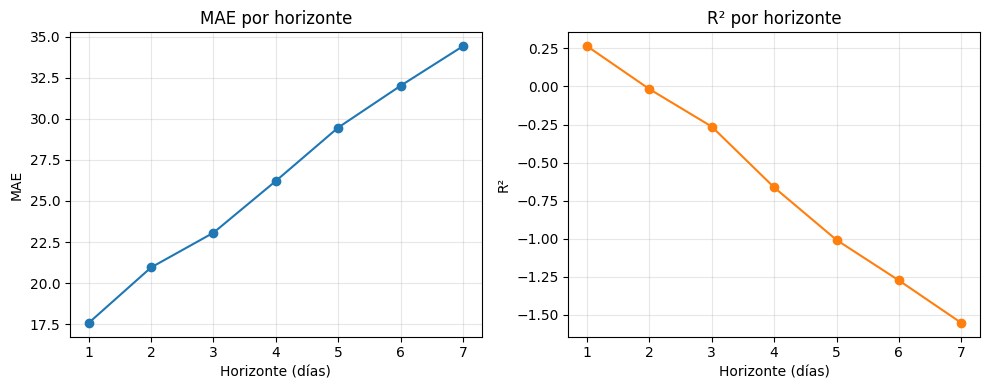

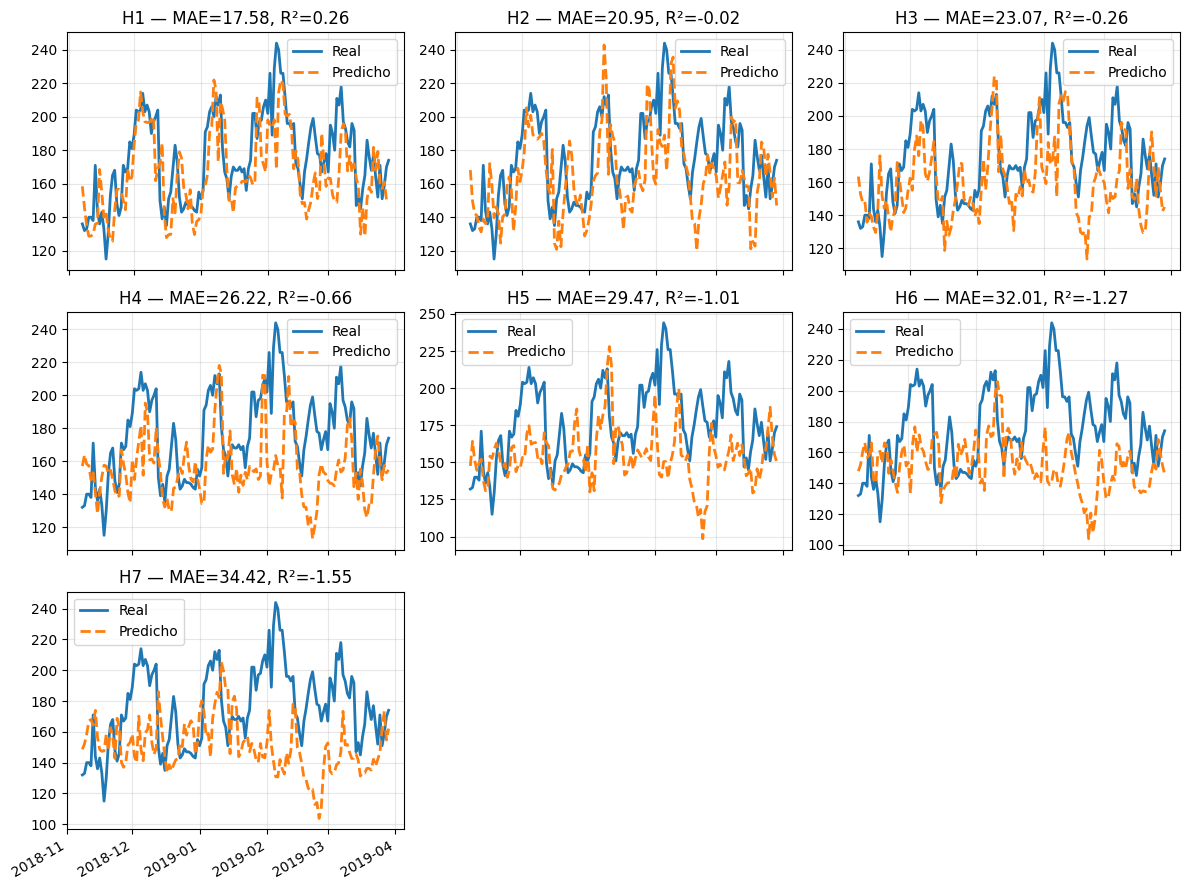

In [5]:
horizontes = range(1, 8)  # 1..7
mae_por_h = []
r2_por_h = []
modelos = {}
results_by_h = {}

for h in horizontes:
    # Crear dataset para este horizonte
    X, Y = crear_dataset_horizonte(y_scaled, N_LAGS, h)

    # Split 80/20
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    # Modelo Gradient Boosting
    gb = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    # Entrenar y predecir
    try:
        gb.fit(X_train, Y_train)
    except Exception as e:
        print(f"Error entrenando horizonte {h}: {e}")
        continue

    modelos[h] = gb
    Y_pred = gb.predict(X_test)

    # Invertir escala para evaluar (asegurarse 2D antes de inverse_transform)
    Y_test_inv = scaler.inverse_transform(Y_test.reshape(-1, 1)).flatten()
    Y_pred_inv = scaler.inverse_transform(Y_pred.reshape(-1, 1)).flatten()

    # Métricas: MAE + R²
    mae = mean_absolute_error(Y_test_inv, Y_pred_inv)
    try:
        r2 = r2_score(Y_test_inv, Y_pred_inv)
    except Exception:
        r2 = float('nan')

    mae_por_h.append(mae)
    r2_por_h.append(r2)

    print(f"Horizonte {h} días → MAE = {mae:.3f}, R² = {r2:.3f}")

    # Reconstruir fechas del conjunto test para este horizonte
    # indices de los targets en la serie original: N_LAGS + h .. N_LAGS + h + len(Y)-1
    targets_indices = np.arange(N_LAGS + h, N_LAGS + h + len(Y))
    test_indices = targets_indices[split:]
    test_dates = df['date'].reset_index(drop=True).iloc[test_indices].values

    # Guardar resultados para graficar
    results_by_h[h] = {
        "dates": test_dates,
        "y_true": Y_test_inv,
        "y_pred": Y_pred_inv,
        "mae": mae,
        "r2": r2
    }

# Opcional: graficar degradación MAE y R²
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(list(horizontes), mae_por_h, marker='o', color='#1f77b4')
plt.title("MAE por horizonte")
plt.xlabel("Horizonte (días)")
plt.ylabel("MAE")
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(list(horizontes), r2_por_h, marker='o', color='#ff7f0e')
plt.title("R² por horizonte")
plt.xlabel("Horizonte (días)")
plt.ylabel("R²")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Panel: real vs predicho por horizonte (incluye MAE y R² en el título)
n = len(horizontes)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), squeeze=False)
axes = axes.flatten()

for idx, h in enumerate(horizontes):
    ax = axes[idx]
    if h not in results_by_h:
        ax.set_visible(False)
        continue

    res = results_by_h[h]
    ax.plot(res["dates"], res["y_true"], label="Real", color="#1f77b4", linewidth=2)
    ax.plot(res["dates"], res["y_pred"], label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"H{h} — MAE={res['mae']:.2f}, R²={res['r2']:.2f}")
    ax.grid(alpha=0.3)
    ax.legend()
    try:
        fig.autofmt_xdate()
    except Exception:
        pass

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Graficamos


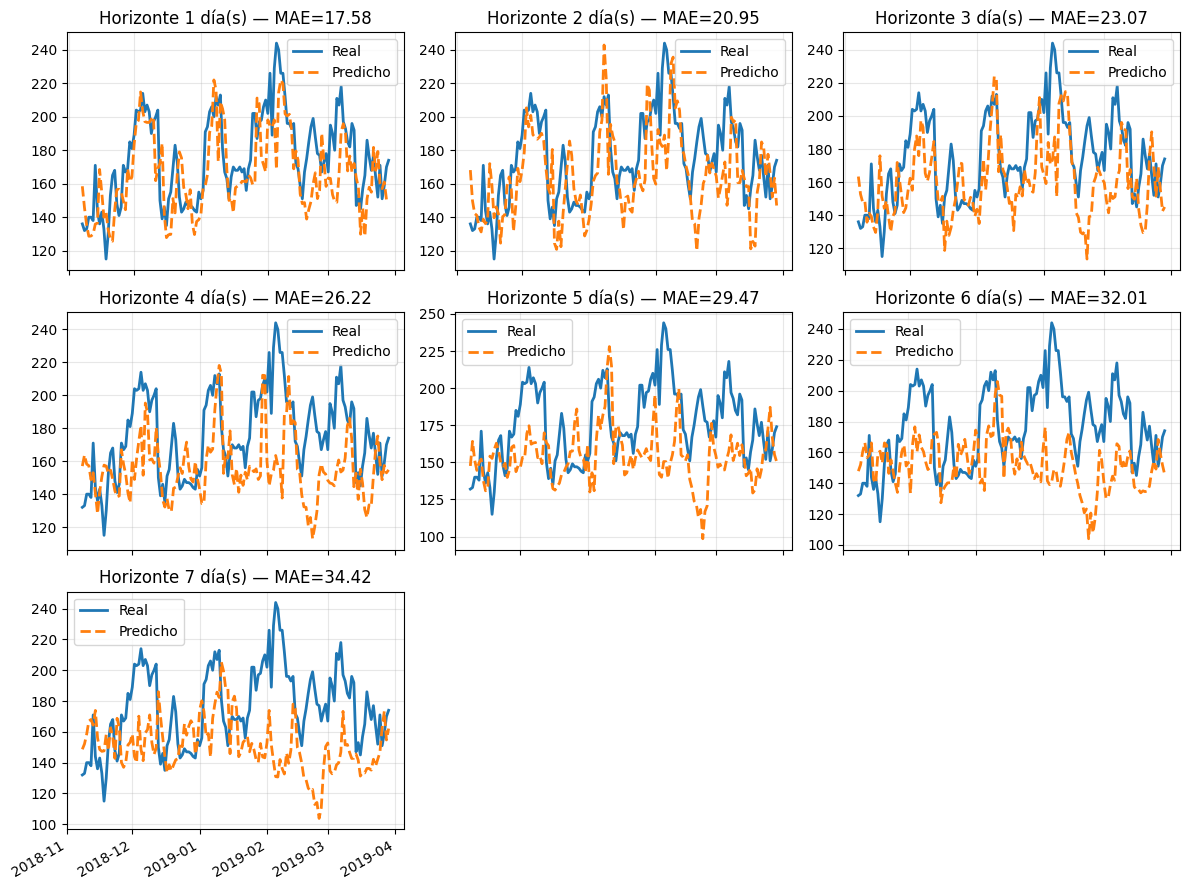

In [6]:
n = len(horizontes)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), squeeze=False)
axes = axes.flatten()

for idx, h in enumerate(horizontes):
    ax = axes[idx]
    if h not in results_by_h:
        ax.set_visible(False)
        continue

    res = results_by_h[h]
    ax.plot(res["dates"], res["y_true"], label="Real", color="#1f77b4", linewidth=2)
    ax.plot(res["dates"], res["y_pred"], label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"Horizonte {h} día(s) — MAE={res['mae']:.2f}")
    ax.grid(alpha=0.3)
    ax.legend()
    # Formato fecha si hay muchas observaciones
    try:
        fig.autofmt_xdate()
    except Exception:
        pass

# Eliminar ejes sobrantes
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# Gradient Boosting con variables exogenas


### Preparamos las variables exogenas


In [7]:
df_weather = pd.read_csv('./data/HDHI_pollution_data.csv')
df_weather['DATE'] = pd.to_datetime(
  df_weather['DATE'], 
  dayfirst=False, 
  errors='coerce'
)


In [9]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df_weather['DATE'] = pd.to_datetime(df_weather['DATE'], errors='coerce')

# Columnas de interés (ajusta nombres si en tu CSV son distintos)
wanted = ['DATE', 'AQI', 'MAX TEMP', 'MIN TEMP', 'HUMIDITY']
present = [c for c in wanted if c in df_weather.columns]

# Seleccionar y, si hay duplicados por fecha, agregarlos por media
dfw_sel = df_weather[present].copy()
if dfw_sel['DATE'].duplicated().any():
    dfw_sel = dfw_sel.groupby('DATE', as_index=False).mean()

# Merge por fecha (left join para conservar daily_counts)
df_exogen = pd.merge(df, dfw_sel, left_on='date', right_on='DATE', how='left')

# Limpiar/renombrar columnas para análisis posterior
df_exogen = df_exogen.drop(columns=['DATE'], errors='ignore').rename(
    columns={
        'AQI': 'aqi',
        'MAX TEMP': 'max_temp',
        'MIN TEMP': 'min_temp',
        'HUMIDITY': 'humidity'
    }
)

# Forzar numérico en las columnas añadidas
for col in ['aqi', 'max_temp', 'min_temp', 'humidity']:
    if col in df_exogen.columns:
        df_exogen[col] = pd.to_numeric(df_exogen[col], errors='coerce')


mean_humidity = df_exogen['humidity'].mean()
df_exogen['humidity'] = df_exogen['humidity'].fillna(mean_humidity).round(2)

df_exogen.head()


,date,num_patients,aqi,max_temp,min_temp,humidity
0,2017-04-01,30,52,40,24,16.0
1,2017-04-02,45,59,40,21,14.0
2,2017-04-03,65,70,39,22,14.0
3,2017-04-04,78,70,39,23,23.0
4,2017-04-05,71,88,36,20,51.0


In [10]:
df_exogen = df_exogen.sort_values('date')
# Extraemos los pacientes y lo convertimos en una matriz columna
y = df_exogen['num_patients'].values.reshape(-1, 1)


In [11]:
df_exogen_proc = df_exogen.copy()

# Convertir toda fecha en día, mes, weekday
for col in df_exogen_proc.select_dtypes(include=['datetime64[ns]']).columns:
    df_exogen_proc[f'{col}_day'] = df_exogen_proc[col].dt.day
    df_exogen_proc[f'{col}_month'] = df_exogen_proc[col].dt.month
    df_exogen_proc[f'{col}_weekday'] = df_exogen_proc[col].dt.weekday
    df_exogen_proc = df_exogen_proc.drop(columns=[col])


## Escalamos ambas series


In [12]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y).flatten()

scaler_x = MinMaxScaler()
X_exogen_scaled = scaler_x.fit_transform(df_exogen_proc.values)


In [13]:
def crear_dataset_exog(series_y, series_exog, n_lags, horizon):
    X_lags, X_exo, Y = [], [], []

    for t in range(n_lags, len(series_y) - horizon):
        X_lags.append(series_y[t-n_lags:t])   # ventana del objetivo
        X_exo.append(series_exog[t])          # exógenas actuales
        Y.append(series_y[t + horizon])       # target futuro

    X_lags = np.array(X_lags)
    X_exo  = np.array(X_exo)
    Y      = np.array(Y)

    # Combinar lags + exógenas
    X_total = np.hstack([X_lags, X_exo])
    return X_total, Y


## Entrenamos el modelo


In [14]:
n_lags = 14
horizontes = range(1, 8)
mae_por_h = []
r2_por_h = []
modelos = {}
results_by_h = {}

for h in horizontes:
    # Crear dataset para horizonte h
    X_total, Y = crear_dataset_exog(
        y_scaled,
        X_exogen_scaled,
        n_lags=n_lags,
        horizon=h
    )

    # Split temporal 80/20
    split = int(len(X_total) * 0.8)
    X_train, X_test = X_total[:split], X_total[split:]
    Y_train, Y_test = Y[:split], Y[split:]

    # Gradient Boosting
    gb = GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    )

    # Entrenar con manejo de errores
    try:
        gb.fit(X_train, Y_train)
    except Exception as e:
        print(f"Error entrenando horizonte {h}: {e}")
        continue

    modelos[h] = gb

    # Predicción
    Y_pred = gb.predict(X_test)

    # Invertir escalas (asegurar 2D antes de inverse_transform)
    Y_test_inv = scaler_y.inverse_transform(Y_test.reshape(-1, 1)).flatten()
    Y_pred_inv = scaler_y.inverse_transform(Y_pred.reshape(-1, 1)).flatten()

    # Métricas: MAE + R²
    mae = mean_absolute_error(Y_test_inv, Y_pred_inv)
    try:
        r2 = r2_score(Y_test_inv, Y_pred_inv)
    except Exception:
        r2 = float('nan')

    mae_por_h.append(mae)
    r2_por_h.append(r2)

    print(f"Horizonte {h} días → MAE = {mae:.3f}, R² = {r2:.3f}")

    # Reconstruir fechas del conjunto test para este horizonte
    targets_indices = np.arange(N_LAGS + h, N_LAGS + h + len(Y))
    test_indices = targets_indices[split:]
    test_dates = df['date'].reset_index(drop=True).iloc[test_indices].values

    # Guardar resultados para graficar (incluye R²)
    results_by_h[h] = {
        "dates": test_dates,
        "y_true": Y_test_inv,
        "y_pred": Y_pred_inv,
        "mae": mae,
        "r2": r2
    }


Horizonte 1 días → MAE = 10.800, R² = 0.704
Horizonte 2 días → MAE = 15.800, R² = 0.440
Horizonte 3 días → MAE = 18.130, R² = 0.267
Horizonte 4 días → MAE = 20.761, R² = -0.005
Horizonte 5 días → MAE = 24.995, R² = -0.412
Horizonte 6 días → MAE = 25.913, R² = -0.564
Horizonte 7 días → MAE = 27.699, R² = -0.689


## Graficos


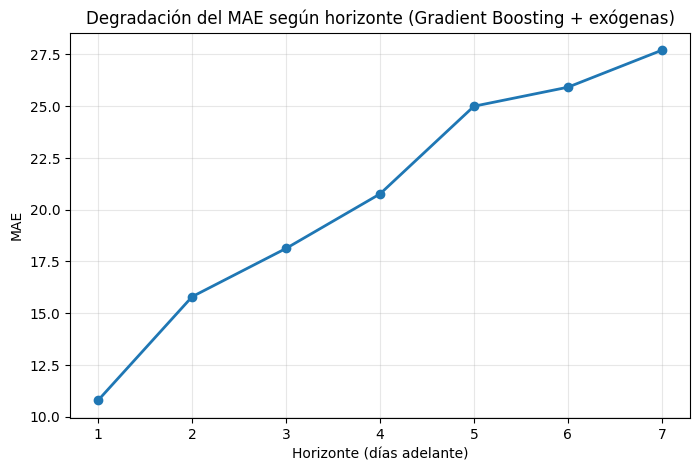

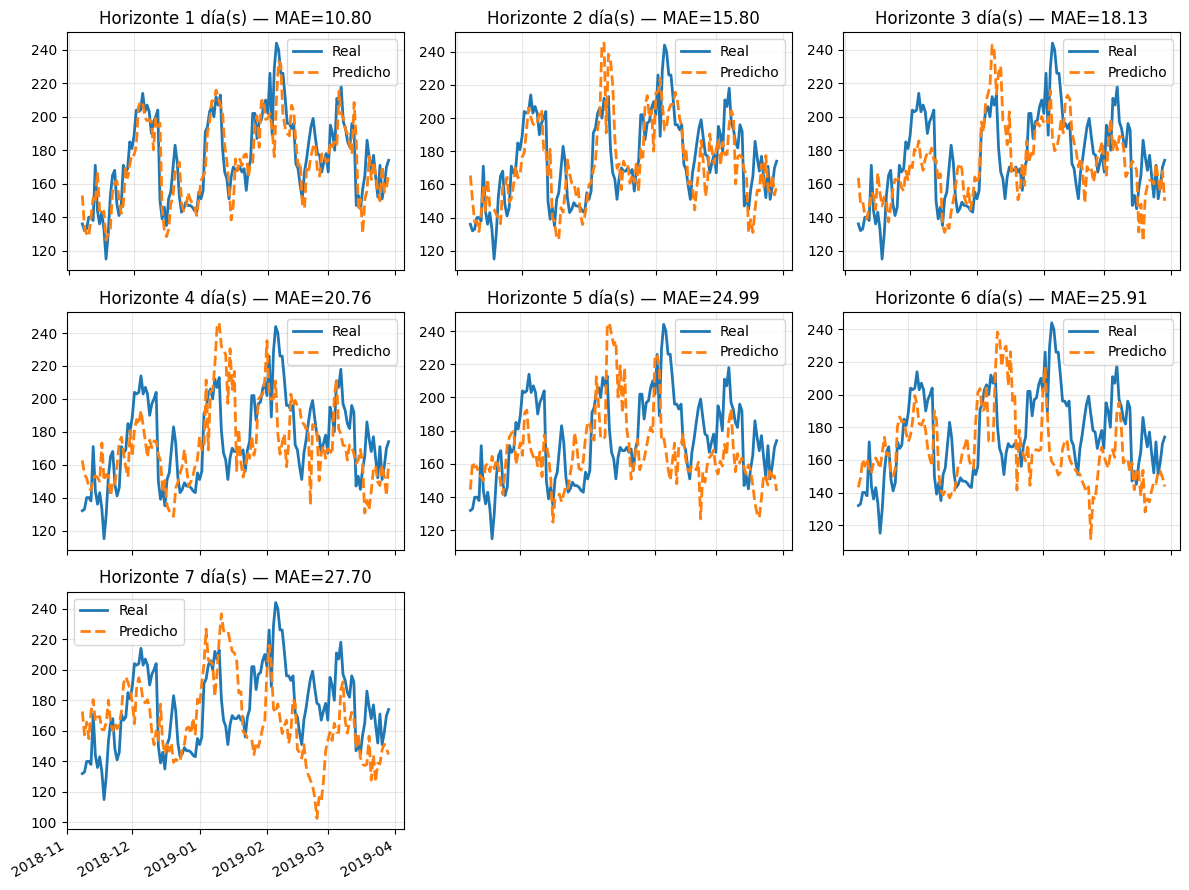

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(list(horizontes), mae_por_h, marker='o', linewidth=2, color="#1f77b4")
plt.title("Degradación del MAE según horizonte (Gradient Boosting + exógenas)")
plt.xlabel("Horizonte (días adelante)")
plt.ylabel("MAE")
plt.grid(alpha=0.3)
plt.show()

# Graficar cada horizonte: serie real vs predicción
n = len(horizontes)
ncols = 3
nrows = math.ceil(n / ncols)
fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), squeeze=False)
axes = axes.flatten()

for idx, h in enumerate(horizontes):
    ax = axes[idx]
    if h not in results_by_h:
        ax.set_visible(False)
        continue

    res = results_by_h[h]
    ax.plot(res["dates"], res["y_true"], label="Real", color="#1f77b4", linewidth=2)
    ax.plot(res["dates"], res["y_pred"], label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)
    ax.set_title(f"Horizonte {h} día(s) — MAE={res['mae']:.2f}")
    ax.grid(alpha=0.3)
    ax.legend()
    try:
        fig.autofmt_xdate()
    except Exception:
        pass

# Eliminar ejes sobrantes si los hay
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Mejor prediccion


In [16]:
# --- Crear ventanas de entrada (n_lags días) y salida (n_future días) ---
def create_lags(series, n_lags=21, n_future=7):
    """
    Convierte una serie temporal en un conjunto supervisado multistep.
    X: ventanas de tamaño n_lags
    y: siguientes n_future valores a predecir
    """
    X, y = [], []
    # Asegurar que series sea 2D
    if len(series.shape) == 1:
        series = series.reshape(-1, 1)
    for i in range(n_lags, len(series) - n_future + 1):
        X.append(series[i - n_lags:i, 0])          # n_lags días previos
        y.append(series[i:i + n_future, 0])        # próximos n_future días
    return np.array(X), np.array(y)

# --- Crear ventanas usando y_scaled ya escalado (convertir a 2D) ---
n_lags = 7
n_future = 7
y_scaled_2d = y_scaled.reshape(-1, 1)
X, y_lagged = create_lags(y_scaled_2d, n_lags, n_future)


In [17]:
# Usar X_exogen_scaled ya escalado de la celda anterior
# Creamos las ventanas usando y_scaled ya escalado
n_lags = 7
y_scaled_2d = y_scaled.reshape(-1, 1)
X_lags, y_target = create_lags(y_scaled_2d, n_lags, n_future=7)
X_exogen_lagged = X_exogen_scaled[n_lags:]

# Alinear tamaños
min_len = min(len(X_lags), len(X_exogen_lagged))
X_lags = X_lags[-min_len:]
X_exogen_lagged = X_exogen_lagged[-min_len:]
y_target = y_target[-min_len:]

# Combinar lags + exógenas
X_total = np.hstack([X_lags, X_exogen_lagged]) 

# División temporal
X_train, X_test, y_train, y_test = train_test_split(
    X_total, y_target, test_size=0.2, shuffle=False
)


In [21]:
# --- Entrenar Gradient Boosting con MultiOutputRegressor para manejar múltiples salidas ---
base_gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb = MultiOutputRegressor(base_gb)
gb.fit(X_train, y_train);


In [22]:
# Realizamos las predicciones sobre el conjunto de test
y_pred = gb.predict(X_test)

# Invertir escalado
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Métricas
mae = mean_absolute_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Evaluación en test:")
print(f"MAE = {mae:.2f}")
print(f"R²  = {r2:.3f}")


Evaluación en test:
MAE = 12.63
R²  = 0.573


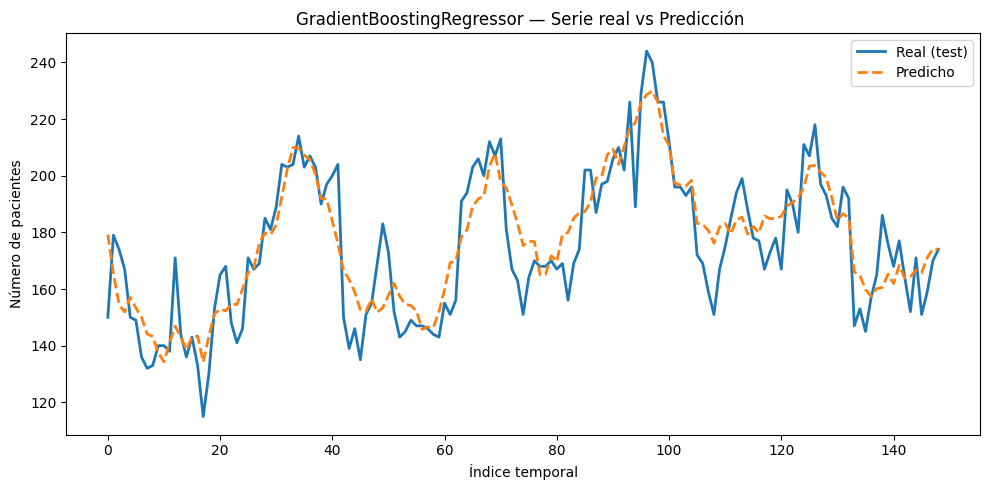

In [23]:
# --- Predicciones ---
y_pred = gb.predict(X_test)

# --- Invertir el escalado ---
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

n_steps_out = 7

# --- Reconstruir serie predicha (promediando solapamientos) ---
n_test_points = len(y_test_inv) + n_steps_out - 1
y_pred_recon = np.zeros(n_test_points)
counts = np.zeros(n_test_points)

for i in range(len(y_pred_inv)):
    for j in range(n_steps_out):
        y_pred_recon[i + j] += y_pred_inv[i, j]
        counts[i + j] += 1

y_pred_recon = y_pred_recon / np.maximum(counts, 1)

# --- Calcular inicio del test ---
# len(y_train) = cantidad de muestras previas a la división 80/20
start_test = len(y) - len(y_test_inv) - n_steps_out + 1

# Porción real equivalente al test
y_test_segment = y[start_test : start_test + len(y_pred_recon)]

# --- Graficar ---
plt.figure(figsize=(10, 5))
plt.plot(y_test_segment, label="Real (test)", color="#1f77b4", linewidth=2)
plt.plot(y_pred_recon, label="Predicho", color="#ff7f0e", linestyle="--", linewidth=2)

plt.title("GradientBoostingRegressor — Serie real vs Predicción ")
plt.xlabel("Índice temporal")
plt.ylabel("Número de pacientes")
plt.legend()
plt.tight_layout()
plt.show()
